In [1]:
#Questions: Are the different coefficients uniform amongst all the nodes in the graph ? Right now, they are equal for all nodes. 
# Yes they should be equal since we are assuming that the effect is shared and we just variate over the value of the feature.
#To easily compute and update the happiness, we keep the following properties true during the evolution of the graph:
# - the attribute contains the happiness of the current node at each step
# - at the begining of a step, the attribute 'happiness_updating' contains coeff_X*X + coeff_Z*Z + coeff_previous_happiness*happiness.
#Therefore we only have to add the influence of all the other nodes at 'happiness_updating' to obtain the updated happiness.

#Here, at each step, we choose a random node and add one friend to it. Then update the happiness of everyone.

In [52]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
import random
import math
import pandas as pd
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as sm

In [51]:
#Defining our global variables:
N_nodes = 5

In [4]:
#Defining graph
G=nx.DiGraph()
G.add_nodes_from(range(N_nodes))

In [5]:
#Defining attributes
for i in range(N_nodes):
    G.node[i]['X'] = random.random()
    G.node[i]['Z'] = random.random()
    G.node[i]['coeff_X'] = 1
    G.node[i]['coeff_Z'] = 1
    G.node[i]['coeff_previous_happiness'] = 1
    G.node[i]['coeff_influence'] = 1
    G.node[i]['happiness'] = G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']
    G.node[i]['happiness_updating'] = G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']+ G.node[i]['coeff_previous_happiness']* G.node[i]['happiness']

In [6]:
#Creating similarity matrices
similarity_matrix = [[0 for i in range(N_nodes)] for j in range(N_nodes)]
observable_matrix = [[0 for i in range(N_nodes)] for j in range(N_nodes)]
similarity_coefficient = 3
for i in range(N_nodes):
    for j in range(i):
        similarity_matrix[i][j] = -similarity_coefficient*math.sqrt((G.node[i]['X'] - G.node[j]['X'])**2 + (G.node[i]['Z'] - G.node[j]['Z'])**2)
        observable_matrix[i][j] = math.sqrt((G.node[i]['X'] - G.node[j]['X'])**2) 
        similarity_matrix[i][j] = 1.0 / (1.0 + math.exp(-similarity_matrix[i][j]))
        similarity_matrix[j][i] = similarity_matrix[i][j]
        observable_matrix[j][i] = observable_matrix[i][j]
        


In [7]:
#Creating set of potential friends for each node
list_potential_friends = [[] for i in range(N_nodes)]
for i in range(N_nodes):
    for j in range(N_nodes):
        if i != j:
            if random.random() < similarity_matrix[i][j]:
                list_potential_friends[i].append(j)

In [8]:
#Function to add to the node "node" a random friend from his list of friends (and to remove him from the list)
def add_one_friend(node, Graph):
    if len(list_potential_friends[node])>0:
        new_friend = random.choice(list_potential_friends[node])
        list_potential_friends[node].remove(new_friend)
        Graph.add_edge(node, new_friend)

In [9]:
#This step is made to add a friend for each node of the Graph
def init_step(Graph):
    for node in range(N_nodes):
        add_one_friend(node, Graph)

In [10]:
#Update happiness 
def update_happiness(Graph):
    for (a,b) in Graph.edges_iter():
        Graph.node[a]['happiness_updating'] +=  G.node[a]['coeff_influence'] *Graph.node[b]['happiness']
    for i in range(N_nodes):
        Graph.node[i]['happiness'] = G.node[i]['happiness_updating']
        Graph.node[i]['happiness_updating'] = G.node[i]['coeff_previous_happiness']*G.node[i]['happiness'] + G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']

In [11]:
def run_step(Graph):
    for node in range(N_nodes):
        add_one_friend(node, Graph)
        update_happiness(Graph)

In [12]:
#NO fixed point algorithm (convergence not guaranteed), rather use the outputs at the previous time.
#Think about best convergence, not go through the nodes in the same way at each step

In [13]:
list_potential_friends

[[2], [2], [0, 3], [0], []]

In [23]:
#Main run for the graph
nb_steps=1
init_step(G)
update_happiness(G)
for i in range(nb_steps):
    run_step(G)

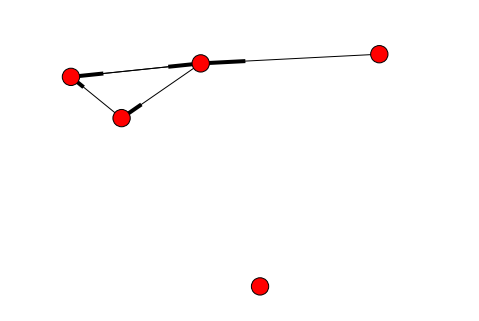

In [24]:
#Plotting the last graph obtained
nx.draw(G)
plt.show()

In [25]:
for edge in G.edges():
    print edge

print (0,2) in G.edges()

(0, 2)
(1, 2)
(2, 0)
(2, 3)
(3, 0)
True


In [46]:
# Creation of Treatment and Response Table
edges = []
treatment = []
response = []
observable = []

for j in range(N_nodes):
    observed_similarity = []
    n_friends = 0
    for i in range(N_nodes):
        if i!=j:
            if (i,j) in G.edges():
                n_friends+=1
                edges.append((i,j))
                treatment.append(True)
                response.append(G.node[i]['happiness'])
                observable.append(G.node[i]['X'])
            else:
                observed_similarity.append((observable_matrix[i][j],(i,j)))
    sorted(observed_similarity)
    for k in range(n_friends):
        control = observed_similarity[k][1]
        edges.append(control)
        treatment.append(False)
        response.append(G.node[control[0]]['happiness'])
        observable.append(G.node[control[0]]['X'])
        
data = pd.DataFrame({'Edges':edges,
                    'Treatment': treatment,
                    'Response': response,
                    'X': observable})
        
        
        

In [47]:
data

,Edges,Response,Treatment,X
0,"(2, 0)",1110.169235,True,0.565452
1,"(3, 0)",633.684312,True,0.685107
2,"(1, 0)",835.639481,False,0.713014
3,"(4, 0)",4.166405,False,0.162307
4,"(0, 2)",838.111265,True,0.795203
5,"(1, 2)",835.639481,True,0.713014
6,"(3, 2)",633.684312,False,0.685107
7,"(4, 2)",4.166405,False,0.162307
8,"(2, 3)",1110.169235,True,0.565452
9,"(0, 3)",838.111265,False,0.795203


In [54]:
result = sm.ols(formula="Response ~ Treatment + X", data=data).fit()

In [55]:
result.params